In [2]:
#import dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st

import requests
import gmaps
import os
from pprint import pprint

#import api keys
from api_keys import g_key
from api_keys import c_key

In [3]:
#create dataframe from csv of breweries, courtesy of OpenBreweryDB (https://github.com/openbrewerydb/openbrewerydb)
brews_df = pd.read_csv ('openbrewerydb.csv')

#isolate breweries in the state of georgia
ga_brews_df = brews_df.loc [brews_df['state'] == 'Georgia', :]

#can exclude breweries in planning, or we can analyze them too
# ga_brews_df = ga_brews_df.loc [ga_brews_df['brewery_type'] != 'planning', :]

ga_brews_df.head()
# ga_brews_df

,id,name,brewery_type,street,address_2,address_3,city,state,county_province,postal_code,website_url,phone,created_at,updated_at,country,longitude,latitude,tags
104,400-north-brewing-sugarhill,400 North Brewing,planning,NaN,NaN,NaN,Sugarhill,Georgia,NaN,30518-7916,http://400northbrewing.com,4047911119,2018-07-24 01:33:15,2018-08-11 21:37:01,United States,NaN,NaN,NaN
123,5-seasons-brewing-co-prado-sandy-springs,5 Seasons Brewing Co - Prado,brewpub,5600 Roswell Rd,NaN,NaN,Sandy Springs,Georgia,NaN,30342-1150,http://www.5seasonsbrewing.com,4042555911,2018-07-24 01:33:15,2018-08-24 00:28:56,United States,-84.379671,33.907809,NaN
124,5-seasons-brewing-co-westside-atlanta,5 Seasons Brewing Co - Westside,brewpub,1000 Marietta St NW Ste 204,NaN,NaN,Atlanta,Georgia,NaN,30318-0683,http://www.5seasonsbrewing.com,4048753232,2018-07-24 01:33:15,2018-08-11 21:37:01,United States,NaN,NaN,NaN
140,6-bridges-brewing-johns-creek,6 Bridges Brewing,planning,NaN,NaN,NaN,Johns Creek,Georgia,NaN,30097,http://www.sixbridgesbrewing.com,7708460292,2018-07-24 01:33:15,2018-08-11 21:37:01,United States,NaN,NaN,NaN
179,abide-brewing-company-newnan,Abide Brewing Company,micro,110 Werz Industrial Blvd Ste 130,NaN,NaN,Newnan,Georgia,NaN,30263-5802,http://www.abidebrewing.com,6789726747,2018-07-24 01:33:15,2018-08-24 00:28:57,United States,-84.763566,33.402570,NaN


In [4]:
#analysis 1: comparing number of types of breweries

#gather frequency of types of breweries, display in dataframe
type_counts = ga_brews_df['brewery_type'].value_counts()

type_counts_df = pd.DataFrame (type_counts)
type_counts_df

,brewery_type
micro,46
brewpub,25
planning,19
large,3
regional,3
contract,2
proprietor,1


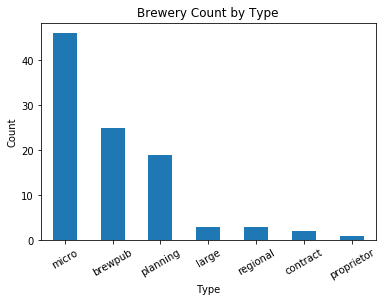

In [5]:
#eduardo
ax = type_counts_df.plot(kind='bar', title='Brewery Count by Type', legend=None)
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.set_xticklabels(type_counts_df.index, rotation=30)
plt.savefig('output/bar1.png')

C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


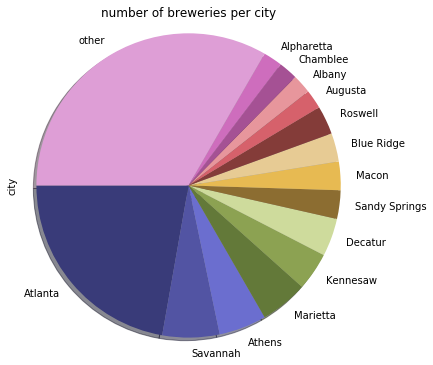

In [6]:
#analysis 2: cities/areas w/ the most breweries

#make sure that all cities are capitalized correctly so nothing is miscounted
ga_brews_df['city'] = ga_brews_df['city'].str.title()

#gather frequencies of these breweries per city, create dataframe
city_counts = ga_brews_df['city'].value_counts()
city_counts_df = pd.DataFrame (city_counts)

#divide cities w/ at least 2 breweries & cities w/ just 1
top_cities_df = city_counts_df.loc [city_counts_df['city'] > 1]
bottom_cities_df = city_counts_df.loc [city_counts_df['city'] == 1]

#total the cities' breweries, create new dataframe to append to top_cities_df
bottom_total = len(bottom_cities_df)
other_cities_df = pd.DataFrame ({'city': [bottom_total]},
                                index = ['other'])

top_cities_df = top_cities_df.append (other_cities_df)

# pretty pie chart
top_cities_df.plot.pie (y = 'city',
                        legend = False,
                        startangle = 180,
                        shadow = True,
                        figsize = (6,6),
                        colormap = "tab20b",
#                         autopct = "%1.1f%%",
                        title = 'number of breweries per city')

plt.axis ("equal")

#export png
plt.savefig ('output/city_pie_chart.png')

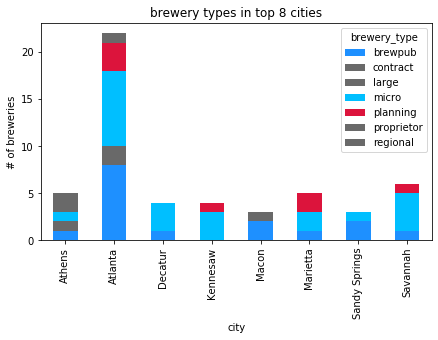

In [7]:
#stacked bar chart using city & type counts in previous 2 cells
stacked_data = ga_brews_df.loc [:, ('city', 'brewery_type')]

#create list of cities w/ only 1 brewery, designate city as 'other' for plotting purposes
# bottom_cities = bottom_cities_df.index

# for city in bottom_cities:
#     stacked_data.loc [stacked_data ['city'] == city, 'city'] = 'other'

#pull top 8 cities
top_cities = top_cities_df[0:8].index

#unfortunately couldn't get the loop to work
stacked_data_top = stacked_data.loc [(stacked_data ['city'] == top_cities[0])|
                                     (stacked_data ['city'] == top_cities[1])|
                                     (stacked_data ['city'] == top_cities[2])|
                                     (stacked_data ['city'] == top_cities[3])|
                                     (stacked_data ['city'] == top_cities[4])|
                                     (stacked_data ['city'] == top_cities[5])|
                                     (stacked_data ['city'] == top_cities[6])|
                                     (stacked_data ['city'] == top_cities[7]), :]
    
# group data by city & brewery type, unstack for plotting
# stacked_data_groups = stacked_data.groupby(['city', 'brewery_type']).size().unstack()
stacked_data_groups = stacked_data_top.groupby(['city', 'brewery_type']).size().unstack()

#plot stacked bar chart
stacked_data_groups.plot.bar(stacked = True,
                             title = 'brewery types in top 8 cities',
                             color = ('dodgerblue', 'dimgrey', 'dimgrey', 'deepskyblue', 'crimson', 'dimgrey', 'dimgrey'),
                             figsize = (7, 4))
plt.ylabel ('# of breweries')

#export png
plt.savefig ('output/stacked_bar_chart.png')

In [8]:
#web scrape largest colleges in georgia w/ pandas, isolate top 15 schools
college_url = 'https://collegestats.org/colleges/georgia/largest/'

college_tables = pd.read_html(college_url)
college_df = college_tables[0][:15]

college_df

,Rank,School Name,City,State,Net Cost,School Level,Retention Rate,# of Students
0,1,University of Georgia,Athens,GA,"$13,287",4 year,94.15%,38473
1,2,Georgia State University,Atlanta,GA,"$15,609",4 year,81.17%,38431
2,3,Georgia Perimeter College,Decatur,GA,"$6,090",2 year,60.9%,32797
3,4,Kennesaw State University,Kennesaw,GA,"$16,232",4 year,78.84%,29558
4,5,Georgia Institute of Technology-Main Campus,Atlanta,GA,"$12,187",4 year,96.03%,24434
5,6,Georgia Southern University,Statesboro,GA,"$16,032",4 year,80.55%,23771
6,7,University of North Georgia,Dahlonega,GA,"$10,262",4 year,82.62%,18793
7,8,South University–Savannah Online,Savannah,GA,NaN,4 year,21.84%,18254
8,9,Chattahoochee Technical College,Marietta,GA,"$2,904",2 year,51.45%,16197
9,10,Emory University,Atlanta,GA,NaN,4 year,95.03%,15852


In [9]:
#remove programs w/ < 60% retention
college_df['RR'] = ''

for x in range(len(college_df['Retention Rate'])):
    stripped = college_df['Retention Rate'][x].strip('%')
    number = float(stripped)
    
    if number < 60:
        college_df = college_df.drop([x])
    else:
        college_df['RR'][x] = number
    
college_df

C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

,Rank,School Name,City,State,Net Cost,School Level,Retention Rate,# of Students,RR
0,1,University of Georgia,Athens,GA,"$13,287",4 year,94.15%,38473,94.15
1,2,Georgia State University,Atlanta,GA,"$15,609",4 year,81.17%,38431,81.17
2,3,Georgia Perimeter College,Decatur,GA,"$6,090",2 year,60.9%,32797,60.9
3,4,Kennesaw State University,Kennesaw,GA,"$16,232",4 year,78.84%,29558,78.84
4,5,Georgia Institute of Technology-Main Campus,Atlanta,GA,"$12,187",4 year,96.03%,24434,96.03
5,6,Georgia Southern University,Statesboro,GA,"$16,032",4 year,80.55%,23771,80.55
6,7,University of North Georgia,Dahlonega,GA,"$10,262",4 year,82.62%,18793,82.62
9,10,Emory University,Atlanta,GA,NaN,4 year,95.03%,15852,95.03
10,11,Valdosta State University,Valdosta,GA,"$13,701",4 year,69.43%,14024,69.43
11,12,University of West Georgia,Carrollton,GA,"$13,988",4 year,74.02%,13802,74.02


In [10]:
clean_college_df = college_df[['School Name', 'City']]

clean_college_df['lat'] = ''
clean_college_df['lng'] = ''

clean_college_df

C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,School Name,City,lat,lng
0,University of Georgia,Athens,,
1,Georgia State University,Atlanta,,
2,Georgia Perimeter College,Decatur,,
3,Kennesaw State University,Kennesaw,,
4,Georgia Institute of Technology-Main Campus,Atlanta,,
5,Georgia Southern University,Statesboro,,
6,University of North Georgia,Dahlonega,,
9,Emory University,Atlanta,,
10,Valdosta State University,Valdosta,,
11,University of West Georgia,Carrollton,,


In [11]:
#begin loop through georgia craft breweries
for index, row in clean_college_df.iterrows():

    #try/except statement in case brewery still can't be found
    try:
        college_loc_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
        college_loc_params = {"query": f"{row['School Name']} {row['City']} georgia",
                              "key": g_key}

        college_loc_response = requests.get(college_loc_url, params = college_loc_params).json()

        clean_college_df.loc[index, 'lat'] = college_loc_response["results"][0]["geometry"]["location"]["lat"]
        clean_college_df.loc[index, 'lng'] = college_loc_response["results"][0]["geometry"]["location"]["lng"]
            
    except:
        pass

clean_college_df = clean_college_df.reset_index (drop = True)
clean_college_df

C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,School Name,City,lat,lng
0,University of Georgia,Athens,33.948,-83.3773
1,Georgia State University,Atlanta,33.7531,-84.3853
2,Georgia Perimeter College,Decatur,33.6889,-84.2749
3,Kennesaw State University,Kennesaw,34.0382,-84.5827
4,Georgia Institute of Technology-Main Campus,Atlanta,33.7756,-84.3963
5,Georgia Southern University,Statesboro,32.4205,-81.7865
6,University of North Georgia,Dahlonega,34.5279,-83.9844
7,Emory University,Atlanta,33.7971,-84.3222
8,Valdosta State University,Valdosta,30.8466,-83.29
9,University of West Georgia,Carrollton,33.5718,-85.1032


In [12]:
#use locate fxn to isolate small production breweries in georgia
ga_microbrews_df = ga_brews_df.loc [(ga_brews_df['brewery_type'] == 'micro')|
                                    (ga_brews_df['brewery_type'] == 'brewpub'), :]

#begin loop through georgia craft breweries
for index, row in ga_microbrews_df.iterrows():
    
    #populate brewery lat/lng into dataframe if missing
    if pd.isna (row['latitude']) is True:
        
        #try/except statement in case brewery still can't be found
        try:
            brew_loc_url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
            brew_loc_params = {"query": f"{row['name']} {row['city']} georgia",
                               "key": g_key}

            brew_loc_response = requests.get(brew_loc_url, params = brew_loc_params).json()

            ga_microbrews_df.loc[index, 'latitude'] = brew_loc_response["results"][0]["geometry"]["location"]["lat"]
            ga_microbrews_df.loc[index, 'longitude'] = brew_loc_response["results"][0]["geometry"]["location"]["lng"]
            
        except:
            pass

#drop any duplicate coordinates if present
ga_microbrews_df.drop_duplicates (subset = ['latitude', 'longitude'], keep = 'first')

ga_microbrews_df

C:\Users\maria\anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,name,brewery_type,street,address_2,address_3,city,state,county_province,postal_code,website_url,phone,created_at,updated_at,country,longitude,latitude,tags
123,5-seasons-brewing-co-prado-sandy-springs,5 Seasons Brewing Co - Prado,brewpub,5600 Roswell Rd,NaN,NaN,Sandy Springs,Georgia,NaN,30342-1150,http://www.5seasonsbrewing.com,4042555911,2018-07-24 01:33:15,2018-08-24 00:28:56,United States,-84.379671,33.907809,NaN
124,5-seasons-brewing-co-westside-atlanta,5 Seasons Brewing Co - Westside,brewpub,1000 Marietta St NW Ste 204,NaN,NaN,Atlanta,Georgia,NaN,30318-0683,http://www.5seasonsbrewing.com,4048753232,2018-07-24 01:33:15,2018-08-11 21:37:01,United States,-84.380170,33.906935,NaN
179,abide-brewing-company-newnan,Abide Brewing Company,micro,110 Werz Industrial Blvd Ste 130,NaN,NaN,Newnan,Georgia,NaN,30263-5802,http://www.abidebrewing.com,6789726747,2018-07-24 01:33:15,2018-08-24 00:28:57,United States,-84.763566,33.402570,NaN
222,akademia-brewing-company-athens,Akademia Brewing Company,brewpub,150 Crane Dr,NaN,NaN,Athens,Georgia,NaN,30606-0600,http://www.AkademiaBC.com,7064613208,2018-07-24 01:33:15,2018-08-24 00:28:58,United States,-83.471538,33.942703,NaN
381,arches-brewing-hapeville,Arches Brewing,micro,3361 Dogwood Dr,NaN,NaN,Hapeville,Georgia,NaN,30354-1439,NaN,6786532739,2018-07-24 01:33:15,2018-08-11 21:37:01,United States,-84.409511,33.662681,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7223,twain-s-brewpub-billiards-decatur,Twain's Brewpub & Billiards,brewpub,211 E Trinity Pl,NaN,NaN,Decatur,Georgia,NaN,30030-3414,http://www.twains.net,4043730063,2018-07-24 01:33:17,2018-08-24 00:29:37,United States,-84.294616,33.772280,NaN
7274,two-tides-brewing-company-savannah,Two Tides Brewing Company,micro,12 West 41st St,NaN,NaN,Savannah,Georgia,NaN,31401,http://www.twotidesbrewing.com,9126670706,2018-07-24 01:33:17,2018-08-24 00:29:38,United States,-81.102161,32.054127,NaN
7384,variant-brewing-company-roswell,Variant Brewing Company,micro,66 Norcross St,NaN,NaN,Roswell,Georgia,NaN,30075-3866,NaN,6782428189,2018-07-24 01:33:17,2018-08-24 00:29:38,United States,-84.359079,34.025768,NaN
7625,wild-heaven-craft-beers-decatur,Wild Heaven Craft Beers,micro,135B Maple St,NaN,NaN,Decatur,Georgia,NaN,30030-3953,http://www.wildheavencraftbeers.com,4049978589,2018-07-24 01:33:17,2018-08-11 21:37:04,United States,-84.275706,33.776451,NaN


In [13]:
#use lats/lngs to create heatmap on gmaps

#configure gmaps
gmaps.configure (api_key = g_key)

#gather coordinates
locs = ga_microbrews_df[["latitude", "longitude"]].astype(float)

#display appropriate zoom level, center in atlanta (ish)
fig1 = gmaps.figure(zoom_level = 6, center = (34, -84))

#create & add heatmap layer
heat_layer = gmaps.heatmap_layer(locs, point_radius = 15)
fig1.add_layer(heat_layer)

#display figure
fig1

Figure(layout=FigureLayout(height='420px'))

In [14]:
#analysis 3: relation b/w microbreweries & colleges/univerisities

#isolate relevant columns to a new dataframe
combined_df = ga_microbrews_df.loc[:, ['name', 'city', 'postal_code', 'latitude', 'longitude']]

#add columns for nearest college data & distance
combined_df['nearest_college'] = ''
combined_df['college_lat'] = ''
combined_df['college_lng'] = ''
combined_df['distance (mi)'] = ''

#!pip install geopy

#import geopy distance to calculate distance b/w two sets of coordinates: each microbrewery/pub & nearest university
from geopy import distance

#loop through dataframe, determine nearest college
for index, row in combined_df.iterrows():
    
    distances = []
    
    #pull coordinates, calculate distance
    brew_coord = (row['latitude'], row['longitude'])
    
    for index2, row2 in clean_college_df.iterrows():
        college_coord = (row2['lat'], row2['lng'])
        college_dist = distance.distance (brew_coord, college_coord).miles
        
        distances.append (college_dist)
        
    list_index = distances.index(min(distances))
    min_dist = min(distances)
    
    #populate dataframe
    combined_df.loc[index, 'nearest_college'] = clean_college_df['School Name'][list_index]
    combined_df.loc[index, 'college_lat'] = clean_college_df['lat'][list_index]
    combined_df.loc[index, 'college_lng'] = clean_college_df['lng'][list_index]
    combined_df.loc[index, 'distance (mi)'] = min_dist

combined_df

,name,city,postal_code,latitude,longitude,nearest_college,college_lat,college_lng,distance (mi)
123,5 Seasons Brewing Co - Prado,Sandy Springs,30342-1150,33.907809,-84.379671,Emory University,33.7971,-84.3222,8.312
124,5 Seasons Brewing Co - Westside,Atlanta,30318-0683,33.906935,-84.380170,Emory University,33.7971,-84.3222,8.26828
179,Abide Brewing Company,Newnan,30263-5802,33.402570,-84.763566,University of West Georgia,33.5718,-85.1032,22.8219
222,Akademia Brewing Company,Athens,30606-0600,33.942703,-83.471538,University of Georgia,33.948,-83.3773,5.42425
381,Arches Brewing,Hapeville,30354-1439,33.662681,-84.409511,Georgia State University,33.7531,-84.3853,6.38398
...,...,...,...,...,...,...,...,...,...
7223,Twain's Brewpub & Billiards,Decatur,30030-3414,33.772280,-84.294616,Emory University,33.7971,-84.3222,2.33715
7274,Two Tides Brewing Company,Savannah,31401,32.054127,-81.102161,Savannah College of Art and Design,32.0691,-81.0938,1.14263
7384,Variant Brewing Company,Roswell,30075-3866,34.025768,-84.359079,Kennesaw State University,34.0382,-84.5827,12.8591
7625,Wild Heaven Craft Beers,Decatur,30030-3953,33.776451,-84.275706,Emory University,33.7971,-84.3222,3.03381


In [15]:
#pull college/university coordinates
college_locations = clean_college_df[['lat', 'lng']]

#create info box to display college names with marker layer
info_template = """<dl>
<dd>{School Name}</dd>
</dl>"""

college_info = [info_template.format(**row) for index, row in clean_college_df.iterrows()]

#add marker layer of colleges to gmaps
college_layer = gmaps.marker_layer (college_locations, info_box_content = college_info)
fig1.add_layer (college_layer)

fig1

Figure(layout=FigureLayout(height='420px'))

In [16]:
#calculate relevant measures of central tendency for distance to C/U
mean_dist = combined_df['distance (mi)'].mean()
median_dist = combined_df['distance (mi)'].median()
min_dist = combined_df['distance (mi)'].min()
max_dist = combined_df['distance (mi)'].max()

#print statement
print (f"""mean: {round (mean_dist, 2)}
median: {round (median_dist, 2)}
min: {round (min_dist, 2)}
max: {round (max_dist, 2)}""")

mean: 17.52
median: 7.3
min: 0.71
max: 98.72


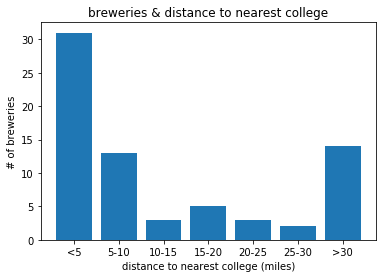

In [18]:
#distance bar chart; max 20.2, min 0ish, mean 3.66

#create bins & labels
dist_bins = [0, 5, 10, 15, 20, 25, 30, 100]
dist_labels = ['<5', '5-10', '10-15', '15-20', '20-25', '25-30', '>30']

#categorize 'distance to C/U' data among bins, add to a new column
combined_df['distance (bin)'] = pd.cut (combined_df['distance (mi)'],
                                               dist_bins,
                                               labels = dist_labels,
                                               include_lowest = True)

#create series of # of colleges in each bin, plot in bar chart
dist_series = combined_df.groupby(['distance (bin)'])['name'].count()
plt.bar (dist_labels, dist_series)

#add axis labels & title
plt.xlabel ('distance to nearest college (miles)')
plt.ylabel ('# of breweries')
plt.title ('breweries & distance to nearest college')

#can alternatively use a box plot, or both
# college_df2['distance to C/U (miles)'].plot.box (grid = True)

#code for export here
plt.savefig ("output/college_bar_chart.png")

In [19]:
#population demographics data
#audrey

#imports
import json

#list of postal codes
ga_brews_df['postal_code']
# print(len(ga_brews_df.index))
# print (postal_code)
count = 0
population_postalcode = []
#r = ga_brews_df.to_dict('index')
#Loop through the postal codes, make a call to the census dataset and pull the population data
for index, row in ga_brews_df.iterrows():
    postal_code=row['postal_code']
    cleaned_five_digit_postal_code=postal_code
    if "-" in postal_code:
        index_of_hyphen = cleaned_five_digit_postal_code.index("-")
        cleaned_five_digit_postal_code=cleaned_five_digit_postal_code[:index_of_hyphen]
#Pull age data for males and females and then add together to produce total for the population
    requestURL = f"https://api.census.gov/data/2017/acs/acs5?key={c_key}&"+\
    "get=B01001_006E,B01001_030E,B01001_007E,B01001_031E,B01001_008E,B01001_032E,B01001_009E,B01001_033E,"+\
    "B01001_010E,B01001_034E,B01001_011E,B01001_035E,B01001_012E,B01001_036E,B01001_013E,B01001_037E,B01001_014E,"+\
    "B01001_038E,B01001_015E,B01001_039E,B01001_016E,B01001_040E,B01001_017E,B01001_041E&for=zip%20code%20tabulation"+\
    "%20area:"+cleaned_five_digit_postal_code
    
    response = requests.get(requestURL)
    if count == 104:
        break
    count += 1
    if response.text !="":
        formattedResponse = json.loads(response.text)[1:]
        Malesage15to17 = int(formattedResponse[0][0])
        Femalesage15to17 = int(formattedResponse[0][1])
        Malesage18and19 = int(formattedResponse[0][2])
        Femalesage18and19 = int(formattedResponse[0][3])
        Malesage20 = int(formattedResponse[0][4])
        Femalesage20 = int(formattedResponse[0][5])
        Malesage21 = int(formattedResponse[0][6])
        Femalesage21 = int(formattedResponse[0][7])
        Malesage22to24 = int(formattedResponse[0][8])
        Femalesage22to24 = int(formattedResponse[0][9])
        Malesage25to29 = int(formattedResponse[0][10])
        Femalesage25to29 = int(formattedResponse[0][11])
        Malesage30to34 = int(formattedResponse[0][12])
        Femalesage30to34 = int(formattedResponse[0][13])
        Malesage35to39 = int(formattedResponse[0][14])
        Femalesage35to39 = int(formattedResponse[0][15])
        Malesage40to44 = int(formattedResponse[0][16])
        Femalesage40to44 = int(formattedResponse[0][17])
        Malesage45to49 = int(formattedResponse[0][18])
        Femalesage45to49 = int(formattedResponse[0][19])
        Malesage50to54 = int(formattedResponse[0][20])
        Femalesage50to54 = int(formattedResponse[0][21])
        Malesage55to59 = int(formattedResponse[0][22])
        Femalesage55to59 = int(formattedResponse[0][23])
        population_postalcode.append({'Postal_Code': cleaned_five_digit_postal_code,
                                      '15to17':Malesage15to17+Femalesage15to17,
                                      '18&19':Malesage18and19+Femalesage18and19,
                                      '20':Malesage20+Femalesage20,
                                      '21' :Malesage21+Femalesage21,
                                     '22to24' :Malesage22to24+Femalesage22to24,
                                     '25to29' :Malesage25to29+Femalesage25to29,
                                     '30to34' :Malesage30to34+Femalesage30to34,
                                     '35to39' :Malesage35to39+Femalesage35to39,
                                     '40to44' :Malesage40to44+Femalesage40to44,
                                     '45to49' :Malesage45to49+Femalesage45to49,
                                     '50to54' :Malesage50to54+Femalesage50to54,
                                     '55to59' :Malesage55to59+Femalesage55to59})
        #print (formattedResponse)
age_demo_df = pd.DataFrame(population_postalcode)

age_demo_df
#ga_brews_df['postal_code']

,Postal_Code,15to17,18&19,20,21,22to24,25to29,30to34,35to39,40to44,45to49,50to54,55to59
0,30518,2535,1249,866,584,1928,2796,3082,3321,4396,4491,3579,3040
1,30342,1338,457,64,269,1141,2731,2874,2529,2232,2317,1690,1581
2,30318,921,1487,1201,871,4426,6790,5197,3706,3344,2245,2346,2142
3,30097,2855,576,375,274,1143,1649,2405,3420,4047,4152,4130,3911
4,30263,2472,1241,797,509,2557,3722,3877,3853,3803,3976,3860,3746
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,30030,752,886,322,381,529,1439,2115,2461,2104,2089,1545,1729
95,31401,310,2309,778,939,1984,2350,1655,831,807,685,716,1040
96,30075,2647,1060,324,346,1007,2417,3127,3456,3654,4514,4966,4144
97,30030,752,886,322,381,529,1439,2115,2461,2104,2089,1545,1729


In [27]:
#example of grouping by age

#drop duplicate zip codes (if any)
age_demo_df.drop_duplicates (subset = 'Postal_Code')

#create column for young adult totals
age_demo_df ['18-29 yo'] = ''
age_demo_df ['total pop'] = ''
age_demo_df ['% YA'] = ''

#begin loop through dataframe
for index, row in age_demo_df.iterrows():
    
    #calculate sum of young adults, total population, & % young adults
    ya_total = (row['18&19'] + row['20'] + row['21'] + row['22to24'] + row['25to29'])
    total_pop = (row['15to17'] + row['18&19'] + row['20'] + row['21'] + row['22to24'] + row['25to29'] + row['30to34'] + row['35to39'] + row['40to44'] + row['45to49'] + row['50to54'] + row['55to59'])
    
    age_demo_df.loc[index, '18-29 yo'] = ya_total
    age_demo_df.loc[index, 'total pop'] = total_pop
    age_demo_df.loc[index, '% YA'] = (ya_total / total_pop) * 100
    
age_demo_df [['18-29 yo', 'total pop', '% YA']]

,18-29 yo,total pop,% YA
0,7423,31867,23.2937
1,4662,19223,24.2522
2,14775,34676,42.6087
3,4017,28937,13.8819
4,8826,34413,25.6473
...,...,...,...
94,3557,16352,21.7527
95,8360,14404,58.0394
96,5154,31662,16.2782
97,3557,16352,21.7527


In [28]:
#measures of central tendency for binning
age_demo_df ['% YA'].agg (['mean', 'median', 'max', 'min'])

mean      31.706278
median    29.281984
max       73.967219
min        0.000000
Name: % YA, dtype: float64

Text(0.5, 1.0, '% of young adults (18-29 yo) & brewery locations')

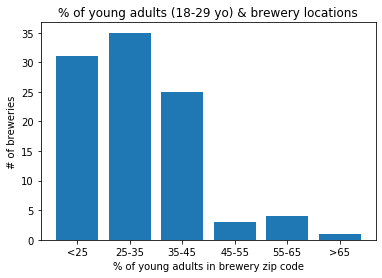

In [29]:
#create bins & labels
age_bins = [0, 25, 35, 45, 55, 65, 80]
age_labels = ['<25', '25-35', '35-45', '45-55', '55-65', '>65']

#categorize '% YA' data among bins, add to a new column
age_demo_df ['% YA (bin)'] = pd.cut (age_demo_df ['% YA'],
                                     age_bins,
                                     labels = age_labels,
                                     include_lowest = True)

#create series of # of breweries in each bin, plot in bar chart
age_series = age_demo_df.groupby(['% YA (bin)'])['Postal_Code'].count()
plt.bar (age_labels, age_series)

#add axis labels & title
plt.xlabel ('% of young adults in brewery zip code')
plt.ylabel ('# of breweries')
plt.title ('% of young adults (18-29 yo) & brewery locations')


In [30]:
#measures of central tendency for binning
age_demo_df ['total pop'].agg (['mean', 'median', 'max', 'min'])

mean      20294.141414
median    19636.000000
max       44280.000000
min         151.000000
Name: total pop, dtype: float64

Text(0.5, 1.0, 'brewery locations & total population')

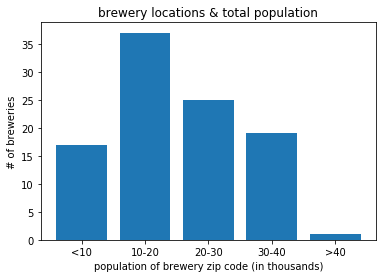

In [31]:
#create bins & labels
pop_bins = [0, 10000, 20000, 30000, 40000, 50000]
pop_labels = ['<10', '10-20', '20-30', '30-40', '>40']

#categorize '% YA' data among bins, add to a new column
age_demo_df ['total pop (bin)'] = pd.cut (age_demo_df ['total pop'],
                                          pop_bins,
                                          labels = pop_labels,
                                          include_lowest = True)

#create series of # of breweries in each bin, plot in bar chart
pop_series = age_demo_df.groupby(['total pop (bin)'])['Postal_Code'].count()
plt.bar (pop_labels, pop_series)

#add axis labels & title
plt.xlabel ('population of brewery zip code (in thousands)')
plt.ylabel ('# of breweries')
plt.title ('brewery locations & total population')

Text(0, 0.5, '# of breweries')

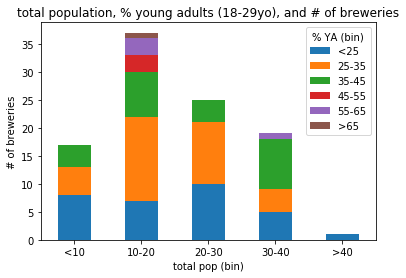

In [32]:
#group by previously created bins, unstack for plotting
pop_groups = age_demo_df.groupby(['total pop (bin)', '% YA (bin)']).size().unstack()

#create stacked bar chart
pop_groups.plot.bar(stacked = True,
                    title = 'total population, % young adults (18-29yo), and # of breweries',
                    rot = 0)
#                              figsize = (7, 4))

plt.ylabel ('# of breweries')

In [36]:
#export dataframes for javascript usage

combined_df.to_csv ('dataframes/college_brewery_df.csv')

age_demo_df.to_csv ('dataframes/age_df.csv')


In [33]:
# Totals['TotalPop'] = Totals['15to17'] + Totals['18&19'] + Totals['20'] + Totals['21'] + Totals['22to24'] + \
#                  Totals['25to29'] + Totals['30to34'] + Totals['35to39'] + Totals['40to44'] + Totals['45to49'] + \
#                  Totals['50to54'] + Totals['55to59']
# # Totals.head(30)
# #Totals.dtypes

# Totals.drop_duplicates(inplace = True)
# #Totals.head(30)

In [34]:
# pops = Totals['TotalPop']
# pops_df = pd.DataFrame(pops)
# pops_df = pops_df.sort_values('TotalPop', ascending=False)
# #pops_df

# pop_thresh = pops_df.iloc[8]
# #pop_thresh

# population_data = Totals.loc [:, ('Postal_Code', 'TotalPop')]
# population_data ['threshold'] = pop_thresh['TotalPop']
# #population_data

# population_data_top = population_data [population_data ['TotalPop'] >= population_data ['threshold']] 
# population_data_top = population_data_top.loc[:, ('Postal_Code', 'TotalPop')]  # takeout threshold
# population_data_top.set_index('Postal_Code', inplace=True)
# #population_data_top

In [35]:
# # group data by zip code & total pop, unstack for plotting
# population_data_top.plot.bar(title = 'total population by zip code',
#                              legend = False)

# plt.savefig ("output/zipcode_bar_chart.png")